In [ ]:
import pandas as pd
from transformers import pipeline
from collections import Counter

df_sample_all = pd.read_csv('liar2/train_sample.csv')
df_sample = df_sample_all[["statement", "label"]]

/Users/matusstanko/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [54]:
from transformers import pipeline

# Load RoBERTa NER model
ner_pipeline_roberta = pipeline("ner", model="Jean-Baptiste/roberta-large-ner-english")

def clean_entity(entity):
    """Removes tokenization artifacts and filters out unwanted characters."""
    word = entity["word"].replace("Ġ", "").strip()  # Remove subword markers
    if len(word) > 1 and word.isalpha():  # Keep only proper words
        return (word, entity["entity"])
    return None  # Ignore bad entities

def extract_entities(text):
    """Runs RoBERTa NER and cleans extracted entities."""
    if isinstance(text, str) and text.strip():
        entities = ner_pipeline_roberta(text)
        return [e for e in (clean_entity(ent) for ent in entities) if e]  # Apply filtering
    return []

# Apply NER extraction + cleaning
df_sample = df_sample.copy()
df_sample.loc[:, "clean_entities"] = df_sample["statement"].apply(extract_entities)

# Show first few rows
df_sample

Device set to use mps:0


,statement,label,entities_roberta,clean_entities
0,"90 percent of Americans ""support universal bac...",5,"[{'entity': 'MISC', 'score': 0.99866974, 'inde...","[(Americans, MISC)]"
1,Last year was one of the deadliest years ever ...,1,[],[]
2,"Bernie Sanders's plan is ""to raise your taxes ...",0,"[{'entity': 'PER', 'score': 0.9983652, 'index'...","[(Bernie, PER), (Sanders, PER)]"
3,Voter ID is supported by an overwhelming major...,4,"[{'entity': 'MISC', 'score': 0.9153447, 'index...","[(NY, MISC), (ers, MISC)]"
4,"Says Barack Obama ""robbed Medicare (of) $716 b...",2,"[{'entity': 'PER', 'score': 0.9980445, 'index'...","[(Barack, PER), (Obama, PER), (Medicare, MISC)..."
5,"Video says COVID-19 vaccines are ""weapons of m...",0,"[{'entity': 'MISC', 'score': 0.999785, 'index'...","[(CO, MISC), (VID, MISC)]"
6,Says Jeff Reardon cut elementary school music ...,2,"[{'entity': 'PER', 'score': 0.99970955, 'index...","[(Jeff, PER), (Re, PER), (ardon, PER)]"


In [47]:
### SPLIT DATA INTO TRUE AND FALSE


true_labels = [3,4, 5]   # True, Mostly-true,    .............Half-true will be skipped
false_labels = [0, 1,2]  # Mostly-false will be skipped.....,False, Pants on Fire

# Split into true and false news DataFrames
df_true = df_sample[df_sample["label"].isin(true_labels)]
df_false = df_sample[df_sample["label"].isin(false_labels)]

# Print dataset sizes
print(f"True news count: {len(df_true)}")
print(f"False news count: {len(df_false)}")

True news count: 2
False news count: 5


In [48]:
df_false

,statement,label,entities_roberta,clean_entities
1,Last year was one of the deadliest years ever ...,1,[],[]
2,"Bernie Sanders's plan is ""to raise your taxes ...",0,"[{'entity': 'PER', 'score': 0.9983652, 'index'...","[(Bernie, PER), (Sanders, PER)]"
4,"Says Barack Obama ""robbed Medicare (of) $716 b...",2,"[{'entity': 'PER', 'score': 0.9980445, 'index'...","[(Barack, PER), (Obama, PER), (Medicare, MISC)..."
5,"Video says COVID-19 vaccines are ""weapons of m...",0,"[{'entity': 'MISC', 'score': 0.999785, 'index'...","[(CO, MISC), (VID, MISC)]"
6,Says Jeff Reardon cut elementary school music ...,2,"[{'entity': 'PER', 'score': 0.99970955, 'index...","[(Jeff, PER), (Re, PER), (ardon, PER)]"


In [49]:
import pandas as pd
from collections import Counter

def count_entities_with_type(df):
    """Counts occurrences of each entity (name, type) and returns a DataFrame."""
    all_entities = [
        (entity[0], entity[1]) for entities in df["clean_entities"] if entities for entity in entities
    ]
    
    entity_counts = Counter(all_entities).most_common()  # Count all entities

    # ✅ Fix: Unpack entity tuple correctly
    df_entities = pd.DataFrame(
        [(ent[0], ent[1], count) for ent, count in entity_counts],
        columns=["Entity", "Type", "Count"]
    )

    return df_entities

# Apply to true and false news
df_true_entities = count_entities_with_type(df_true)
df_false_entities = count_entities_with_type(df_false)


df_true_entities


,Entity,Type,Count
0,Americans,MISC,1
1,NY,MISC,1
2,ers,MISC,1


In [50]:
df_false_entities

,Entity,Type,Count
0,Bernie,PER,1
1,Sanders,PER,1
2,Barack,PER,1
3,Obama,PER,1
4,Medicare,MISC,1
5,Obamacare,MISC,1
6,CO,MISC,1
7,VID,MISC,1
8,Jeff,PER,1
9,Re,PER,1


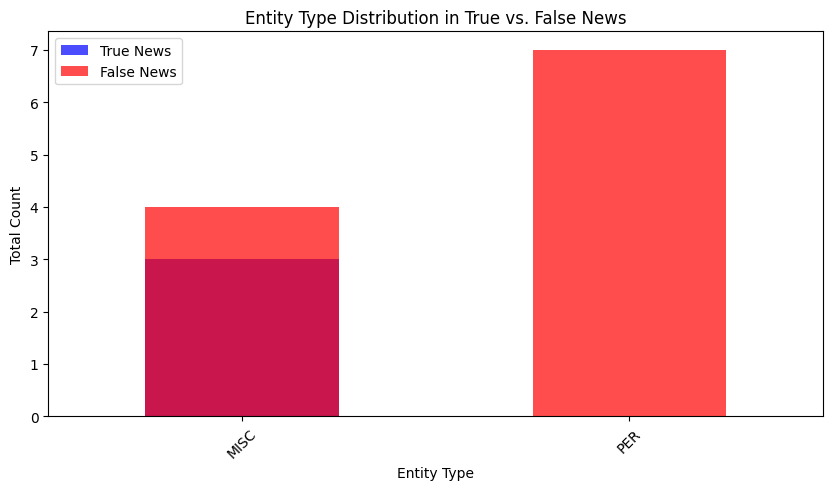

In [51]:
import matplotlib.pyplot as plt

# Aggregate counts by entity type for true and false news
true_entity_type_counts = df_true_entities.groupby("Type")["Count"].sum()
false_entity_type_counts = df_false_entities.groupby("Type")["Count"].sum()

# Create bar charts for comparison
plt.figure(figsize=(10, 5))
true_entity_type_counts.plot(kind="bar", color="blue", alpha=0.7, label="True News")
false_entity_type_counts.plot(kind="bar", color="red", alpha=0.7, label="False News")

# Labels and legend
plt.xlabel("Entity Type")
plt.ylabel("Total Count")
plt.title("Entity Type Distribution in True vs. False News")
plt.legend()
plt.xticks(rotation=45)

# Show plot
plt.show()

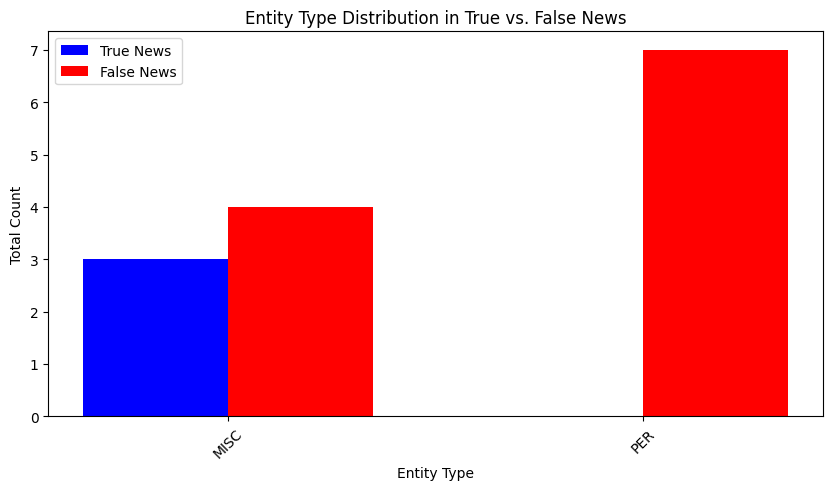

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Get entity types and their counts
true_counts = df_true_entities.groupby("Type")["Count"].sum()
false_counts = df_false_entities.groupby("Type")["Count"].sum()

# Align both datasets to have the same entity types
all_types = list(set(true_counts.index).union(set(false_counts.index)))
true_counts = true_counts.reindex(all_types, fill_value=0)
false_counts = false_counts.reindex(all_types, fill_value=0)

# Set up bar positions
x = np.arange(len(all_types))
width = 0.35  # Bar width

# Create the figure
plt.figure(figsize=(10, 5))

# Plot bars side by side
plt.bar(x - width/2, true_counts, width, color="blue", label="True News")
plt.bar(x + width/2, false_counts, width, color="red", label="False News")

# Labels and styling
plt.xlabel("Entity Type")
plt.ylabel("Total Count")
plt.title("Entity Type Distribution in True vs. False News")
plt.xticks(x, all_types, rotation=45)
plt.legend()

# Show plot
plt.show()